Pseudo arc-length continuation in the CR3BP
=====================================

In this example we will refine the basic continuation scheme used in [Continuation of Periodic Orbits in the CR3BP](<./Periodic orbits in the CR3BP.ipynb>) and use instead, as continuation parameter, the pseudo arc-length.

The resulting numerical scheme allows to follow through folds of the curve implicitly defined by the periodicity condition and the Poincare' phasing condition.

## Preamble
As usual, we make some standard imports:

In [1]:
import heyoka as hy
import numpy as np
import time 

from scipy.optimize import least_squares, root_scalar
from copy import deepcopy

from matplotlib.pylab import plt

%matplotlib notebook 

... and define some functions that will help later on to visualize our trajectories and make nice plots. (ignore them and come back to this later in case you are curious)

In [2]:
def compute_L_points(mu, f):
    """Computes The exact position of the Lagrangian points. To do so it finds the zeros of the
    the dynamics equation for px.
    
        Args:
            mu (float): The value of the mu parameter.
            f (heyoka expression): The px dynamics equation.

        Returns:
            xL1, xL2, xL3, xL45, yL45: The coordinates of the various Lagrangian Points
    """
    # Position of the lagrangian points approximated
    xL1 = (mu-1) + (mu/3/(1-mu))**(1/3)
    xL2 = (mu-1) - (mu/3/(1-mu))**(1/3)
    xL3 = -(mu-1) - 7/12 * mu / (1-mu)
    yL45 = np.sin(60/180*np.pi)
    xL45 = -0.5 + mu

    # Solve for the static equilibrium from the approximated solution
    def equilibrium(expr, x,y):
        retval = hy.eval(expr, {"x":x, "y":y, "z":0, "px":-y, "py":x, "pz":0}, [mu])
        return retval
    xL1 = root_scalar(lambda x: equilibrium(f, x,0.), x0=xL1,x1=xL1-1e-2).root
    xL2 = root_scalar(lambda x: equilibrium(f, x,0.), x0=xL2,x1=xL2-1e-2).root
    xL3 = root_scalar(lambda x: equilibrium(f, x,0.), x0=xL3,x1=xL3-1e-2).root;
    return xL1, xL2, xL3, xL45, yL45

def potential_function(position,mu):
    """Computes the system potential
        Args:
            position (array-like): The position in Cartesian coordinates
            mu (float): The value of the mu parameter.

        Returns:
            The potential
    """
    x,y,z=position
    r_1=np.sqrt((x-mu)**2+y**2+z**2)
    r_2=np.sqrt((x-mu+1)**2+y**2+z**2)
    Omega=1./2.*(x**2+y**2)+(1-mu)/r_1+mu/r_2
    return Omega

def jacobi_constant(state,mu):
    """Computes the system Jacobi constant
        Args:
            state (array-like): The system state (x,y,z,px,py,pz)
            mu (float): The value of the mu parameter.

        Returns:
            The Jacobi constant for the state
    """
    x,y,z,px,py,pz=state
    vx = px + y
    vy = py - x
    vz = pz
    r_1=np.sqrt((x-mu)**2+y**2+z**2)
    r_2=np.sqrt((x-mu+1)**2+y**2+z**2)
    Omega=1/2*(x**2+y**2)+(1-mu)/r_1+mu/r_2
    T=1/2*(vx**2+vy**2+vz**2)
    C=Omega-T
    return C

We also define the CR3BP equations ... (see [circular restricted three-body problem](<./The restricted three-body problem.ipynb>)) 

In [3]:
# Create the symbolic variables.
symbols_state = ["x", "y", "z", "px", "py", "pz"]
x = np.array(hy.make_vars(*symbols_state))
# This will contain the r.h.s. of the equations
f = []

rps_32 = ((x[0] - hy.par[0])**2 + x[1]**2 + x[2]**2)**(-3/2.)
rpj_32 = ((x[0] - hy.par[0]  + 1.)**2 + x[1]**2 + x[2]**2)**(-3/2.)

# The equations of motion.
f.append(x[3] + x[1])
f.append(x[4] - x[0])
f.append(x[5])
f.append(x[4] - (1. - hy.par[0]) * rps_32 * (x[0] - hy.par[0]) - hy.par[0] * rpj_32 * (x[0] - hy.par[0] + 1.))
f.append(-x[3] -((1. - hy.par[0]) * rps_32 + hy.par[0] * rpj_32) * x[1])
f.append(-((1. - hy.par[0]) * rps_32 + hy.par[0] * rpj_32) * x[2])
f = np.array(f)

and the corresponding variational equations (see and [Continuation of Periodic Orbits in the CR3BP](<./Periodic orbits in the CR3BP.ipynb>))), essentially computing the state transition matrix $\mathbf \Phi$.

In [4]:
symbols_phi = []
for i in range(6):
    for j in range(6):
        # Here we define the symbol for the variations
        symbols_phi.append("phi_"+str(i)+str(j))  
phi = np.array(hy.make_vars(*symbols_phi)).reshape((6,6))

In [5]:
dfdx = []
for i in range(6):
    for j in range(6):
        dfdx.append(hy.diff(f[i],x[j]))
dfdx = np.array(dfdx).reshape((6,6))

In [6]:
# The (variational) equations of motion
dphidt = dfdx@phi

Finally, we create the dynamics including all 6 + 6x6 = 42 equations:

In [7]:
dyn = []
for state, rhs in zip(x,f):
    dyn.append((state, rhs))
for state, rhs in zip(phi.reshape((36,)),dphidt.reshape((36,))):
    dyn.append((state, rhs))
# These are the initial conditions on the variational equations (the identity matrix)
ic_var = np.eye(6).reshape((36,)).tolist()

and instantiate the Taylor integrator (high accuracy and no compact mode)

In [8]:
start_time = time.time()
ta = hy.taylor_adaptive(
    # The ODEs.
    dyn,
    # The initial conditions.
    [-0.45, 0.80, 0.00, -0.80, -0.45, 0.58] + ic_var,
    # Operate below machine precision
    # and in high-accuracy mode.
    tol = 1e-18, high_accuracy = True
)
print("--- %s seconds --- to build the Taylor integrator" % (time.time() - start_time))

--- 9.735999822616577 seconds --- to build the Taylor integrator


## The Pseudo arc-length continuation method
In the most general form, and in a nutshell, numerical continuation considers a starting equation in the form:
$$
\underline{{\mathbf G}}\left(\underline{ \mathbf x}, \lambda\right) = \underline{\mathbf 0}
$$
assumes a solution $\underline{ \mathbf x}_0, \lambda_0$ is available and seeks a new solution $\underline{ \mathbf x}_0+\delta\underline{\mathbf{x}}$ corrisponding to $\lambda_0+\delta \lambda$. In cases where the solution curve implicitly defined by $\underline{{\mathbf G}}$ folds with respect to the continuation parameter $\lambda$, this becomes clearly problematic. A common solution is to consider a new continuation parameter intrinsically linked to the solution curve geometry: the curve arc-length $s$. Assuming as reference $s=s_0$ in $\underline{ \mathbf x}_0, \lambda_0$, the arc-length can be considered as a function of $\underline{\mathbf{x}}$ and $\lambda$. We can then write $s = \tilde s\left(\underline{ \mathbf x}, \lambda\right)$.

Under this idea one can formally write:
$$
\left\{
\begin{array}{l}
\underline{{\mathbf G}}\left(\underline{ \mathbf x}, \lambda\right) = \underline{\mathbf 0} \\
\tilde s\left(\underline{ \mathbf x}, \lambda\right) - s = 0
\end{array}
\right.
$$
or, equivalently:
$$
\underline{{\mathbf G}}^*\left(\underline{ \mathbf y}, s\right) = \underline{\mathbf 0}
$$
where $\underline{ \mathbf y} = [\underline{ \mathbf x}, \lambda ]$ and $\underline{\mathbf G}^*=[\underline{\mathbf G}, \tilde s - s]$. Starting from the solution $\underline{ \mathbf x}_0, \lambda_0, s_0$ we have reformulated the problem and may now seek a new solution $[\underline{ \mathbf x}_0+\delta\underline{\mathbf{x}}, \lambda_0+\delta \lambda]$ corresponding to $s_0+\delta s$. We obtain (at least formally) a continuation scheme able to follow easily through folds of the $\underline{ \mathbf x}, \lambda$ curve, since the $\underline{ \mathbf y}, s$ curve has none! (the arc-length is always uniformly increasing along the solution curve).

The problem now is that we cannot really compute $\tilde s$ easily! But we can approximate $\delta s$ as the projection of $[\delta \underline{ \mathbf x}, \delta \lambda]$ onto the tangent vector $\mathbf \tau = \left[\frac{d\underline{ \mathbf x}}{ds}, \frac{d\lambda}{ds}\right]$ (hence the name **pseudo** arc-length is used). Eventually, the system:
$$
\left\{
\begin{array}{l}
\underline{{\mathbf G}}\left(\underline{ \mathbf x}_0+\delta \underline{ \mathbf x}, \lambda_0+\delta \lambda\right) = \underline{\mathbf 0} \\
\mathbf \tau \cdot [\delta \underline{ \mathbf x}, \delta \lambda] -  \delta s = 0
\end{array}
\right.
$$
is considered.

### The case of continuing periodic orbits.
In the case of a search for periodic solutions to the system $\dot{\underline{\mathbf x}} =\underline{ \mathbf f}(\underline{\mathbf x})$ we indicate the generic solution as $\underline{ \mathbf x}\left(t; \underline{ \mathbf x}_0\right)$ and may thus write the periodicity condition as:
$$
(1) \qquad \underline{ \mathbf x}\left(T; \underline{ \mathbf x}_0\right) - \underline{ \mathbf x}_0 = \mathbf 0
$$
We thus search for $\underline{ \mathbf x}_0, T$ roots of the equation above. Assuming we have one such solution, we will slightly abuse the notation and omit a further $0$ as a subscript in $\underline{\mathbf x}_0$ indicating such an initial solution simply as as $\underline{\mathbf x}_0, T_0$. To continue this initial solution we seek $\delta\underline{\mathbf x}$ and $\delta T$ so that:
$$
\underline{ \mathbf x}\left(T_0 + \delta T; \underline{ \mathbf x}_0 + \delta\underline{\mathbf x}\right) - \underline{ \mathbf x}_0 - \delta\underline{\mathbf x}= \mathbf 0
$$
In other words we are perturbing our initial condition and period and demand to end up in a new periodic orbit. It is straight forward to see that for any fixed $\delta T$ there is more than one $\underline{ \mathbf x}_0$ that would do the trick. Infact any point on the whole new periodic orbit would work! Thus, as we saw also in [Continuation of Periodic Orbits in the CR3BP](<./Periodic orbits in the CR3BP.ipynb>), we need to add the Poincare' phasing condition and search, instead for a solution to the system:
$$
\left\{
\begin{array}{l}
\underline{ \mathbf x}\left(T_0 + \delta T; \underline{ \mathbf x}_0 + \delta\underline{\mathbf x}\right) - \underline{ \mathbf x}_0 - \delta\underline{\mathbf x}= \mathbf 0 \\ 
\delta \underline{\mathbf x} \cdot \underline{\mathbf f} (\underline{ \mathbf x}_0) = 0
\end{array}
\right.
$$
this (both equations) is our $\underline{{\mathbf G}} = \underline{\mathbf 0}$ with $\delta T$ being our continuation parameter. We now apply the pseudo arc-length condition to avoid issues when the solution curve folds for increasing periods. We get:
$$
(2) \qquad
\left\{
\begin{array}{l}
\underline{ \mathbf x}\left(T_0 + \delta T; \underline{ \mathbf x}_0 + \delta\underline{\mathbf x}\right) - \underline{ \mathbf x}_0 - \delta\underline{\mathbf x}= \mathbf 0 \\ 
\delta \underline{\mathbf x} \cdot \underline{\mathbf f} (\underline{ \mathbf x}_0) = 0 \\
\mathbf \tau \cdot [\delta \underline{ \mathbf x}, \delta T] = \delta s
\end{array}
\right.
$$

where $\mathbf \tau$ is found differentiating  with respect to $s$ our $\underline{{\mathbf G}}$ considering both $\delta\underline{\mathbf x}(s)$ and $\delta T(s)$ as a function of $s$ and then applying a normalization.

### Predictor
If we expand in Taylor series the relation (2) we get:
$$
\left\{
\begin{array}{l}
(\underline{\underline{\mathbf \Phi}}-\underline{\underline{\mathbf I}})\delta\underline{\mathbf x} + \underline{\mathbf f} \delta T = \underline{\mathbf 0}\\ 
\delta \underline{\mathbf x} \cdot \underline{\mathbf f} (\underline{ \mathbf x}_0) = 0 \\
\mathbf \tau \cdot [\delta \underline{ \mathbf x}, \delta T] = \delta s
\end{array}
\right.
$$
which for the basis to get a first guess (predictor) on the new continued state. 

It is convenient to assemble the following matrix:
$$
\underline{\underline{\mathbf A}} = 
\left[
\begin{array}{cc}
\underline{\underline{\mathbf \Phi}}-\underline{\underline{\mathbf I}} & \underline {\mathbf f} \\
\underline {\mathbf f}^T & 0 \\
\underline {\mathbf \tau}_x^T & \tau_T
\end{array}
\right]
$$
then, the predictor scheme, becomes:

In [9]:
# Single iteration from ic, t_final, ds
def predictor(x0, T0, ds):
    # 1 - We compute the state transition matrix Phi (integrating the full EOM for t_final)
    ta.time = 0.
    ta.state[:] = x0.tolist() + ic_var
    out = ta.propagate_until(T0)
    Phi = ta.state[6:].reshape((6,6))
    # 2 - We compute the dynamics f (at zero, but for periodic orbits this is the same at T)
    state_dict = {"x":x0[0], "y":x0[1], "z":x0[2], "px":x0[3], "py":x0[4], "pz":x0[5]}
    f_dyn = np.array([hy.eval(f[i], state_dict, [mu]) for i in range(6)]).reshape((-1,1))
    # 3 - Assemble the matrix A
    A = np.concatenate((Phi-np.eye(6), f_dyn.T))
    A = np.concatenate((A,np.insert(f_dyn,-1,0).reshape((-1,1))), axis=1)
    # 4 - Compute the tangent vector tau
    tauT = 1
    taux = - np.linalg.inv(A[:,:6].T@A[:,:6])@(A[:,:6].T@A[:,-1]) * tauT
    norm = np.sqrt(taux@taux + tauT*tauT)
    tauT/=norm
    taux/=norm
    # 5 - Add to the matrix A
    tmp = np.insert(taux,6,tauT).reshape(1,-1)
    A = np.concatenate((A, tmp))
    # 6 - Compute the b vector
    b = np.zeros((8,1))
    b[7,0] = ds
    # 6 - Predict an initial guess
    y = np.linalg.inv(A.T@A)@(A.T@b)
    return y, taux, tauT

Lets instantiate our periodic solution. It is the same Lyapunov orbit we have used in the example [Continuation of Periodic Orbits in the CR3BP](<./Periodic orbits in the CR3BP.ipynb>). 

In [10]:
# These conditions correspond to a Lyapunov orbit closeto the L2 point
ic = np.array([-8.3660628427188066e-01, 6.8716725011222035e-05, 0.0000000000000000e+00, -2.3615604665605682e-05, -8.3919863043620713e-01, 0.0000000000000000e+00])
t_final=2.6915996001673941e+00
mu=0.01215057
ta.pars[0] = mu
# Pseudo arc-length
ds = 1e-3

In [11]:
# We call the predictor
predicted, taux, tauT = predictor(ic, t_final, ds)

# Corrector
We now want to find  $\delta \underline{\mathbf y} = [\delta \underline{\mathbf{x}}, \delta T]$ so that the system of equations (2), reported again below for convenience, is satisfied:
$$
(2)
\qquad
\left\{
\begin{array}{l}
\underline{ \mathbf x}\left(T_0 + \delta T; \underline{ \mathbf x}_0 + \delta\underline{\mathbf x}\right) - \underline{ \mathbf x}_0 - \delta\underline{\mathbf x}= \mathbf 0 \\ 
\delta \underline{\mathbf x} \cdot \underline{\mathbf f} (\underline{ \mathbf x}_0) = 0 \\
\mathbf \tau \cdot [\delta \underline{ \mathbf x}, \delta T] = \delta s
\end{array}
\right.
$$
and can start from the guess returned by the predictor step.

Different methods can be used to solve the overdetermined system of equations above (which admits a unique solution), we here use the least-square method implemented in scipy and also give our own implementation of a Newton based method.

First, we need to define a function that checks, for some $\delta\underline{\mathbf y} = [\delta \underline{\mathbf{x}}, \delta T]$, whether the equations (2) are satistied.

In [12]:
def full_system(X0, T0, dy, taux, tauT, ds):
    dx = deepcopy(dy[:6])
    dT = deepcopy(dy[6])
    x = X0 + dx
    propagation_time = T0 + dT
    # 1 - We compute the state at propagation_time
    ta.time = 0.
    ta.state[:] = x.tolist() + ic_var
    out = ta.propagate_until(propagation_time)
    # 2 - We compute the dynamics f (at zero, but for periodic orbits this is the same at T)
    state_dict = {"x":X0[0], "y":X0[1], "z":X0[2], "px":X0[3], "py":X0[4], "pz":X0[5]}
    f_dyn0 = np.array([hy.eval(f[i], state_dict, [mu]) for i in range(6)]).reshape((-1,1))
    # 3 - Error on the state
    state_err = ta.state[:6] - x
    # Error on Poincare phasing
    poin_err = dx@f_dyn0
    # Error on pseudo arc-length
    pseudo_err = taux@dx+tauT*dT - ds
    # 4 - Assemble return value
    retval = np.insert(state_err,6, poin_err)
    retval = np.insert(retval,7, pseudo_err)
    Phi = ta.state[6:].reshape((6,6))
    return retval, Phi

... we can then call the scipy.optimze.least_squares method that will estimate gradients numerically.

In [13]:
# A least squared corrector
def corrector_ls(X0, T0, dy0, taux, tauy, ds, tol = 1e-12):
    sol = least_squares(lambda dy: full_system(X0, T0, dy, taux, tauT, ds)[0], dy0, ftol = tol)
    return sol.x

In [14]:
corrected_ls = corrector_ls(ic, t_final, predicted[:,0], taux, tauT, ds, tol=1e-14)

Here we implement our own Newton based method making use of the variational equations to compute the necessary gradient.

In [15]:
def corrector_Newton(X0, T0,dy, taux, tauy, ds, tol=1e-12, max_iter=100, verbose = False):  
    flag_tol = False
    
    curr_dx = deepcopy(dy[:6])
    curr_dT = deepcopy(dy[6])
    
    # Linearization point
    curr_x = X0 + curr_dx.T
    curr_T = T0 + curr_dT
    
    for i in range(max_iter):
        # 1 - We compute the state transition matrix Phi (integrating the full EOM from curr_x for t_final)
        ta.time = 0.
        ta.state[:] = curr_x.tolist() + ic_var
        out = ta.propagate_until(curr_T)
        Phi = ta.state[6:].reshape((6,6))
        # 2 - We compute the dynamics f (at the initial state)
        state_dict = {"x":X0[0], "y":X0[1], "z":X0[2], "px":X0[3], "py":X0[4], "pz":X0[5]}
        f_dyn0 = np.array([hy.eval(f[i], state_dict, [mu]) for i in range(6)]).reshape((-1,1))
        # 3 - We compute the dynamics f (at curr_T)
        state_dict = {"x":ta.state[0], "y":ta.state[1], "z":ta.state[2], "px":ta.state[3], "py":ta.state[4], "pz":ta.state[5]}
        f_dynT = np.array([hy.eval(f[i], state_dict, [mu]) for i in range(6)]).reshape((-1,1))
        # 4 - Assemble the function (the full nonlinear system) value at the current point
        state_err = ta.state[:6] - curr_x
        # Error on Poincare phasing
        poin_err = curr_dx@f_dyn0
        # Error on pseudo arc-length
        pseudo_err = taux@curr_dx+tauT*curr_dT - ds
        b = np.zeros((8,1))
        b[:6,0] = - state_err
        b[6,0] = - poin_err
        b[7,0] = - pseudo_err
        if verbose:
            print(np.linalg.norm(state_err), poin_err, pseudo_err)
        toterror = np.abs(np.linalg.norm(state_err)) + np.abs(poin_err) + np.abs(pseudo_err)
        if toterror < tol:
            flag_tol = True
            break
        # 5 - Assemble the matrix A (gradient)
        A = np.concatenate((Phi-np.eye(6), f_dynT.T))
        A = np.concatenate((A,np.insert(f_dynT,-1,0).reshape((-1,1))), axis=1)
        # add the tau row
        tmp = np.insert(taux,6,tauT).reshape(1,-1)
        A = np.concatenate((A, tmp))
        
        # Solve for new y = [dx, dT]
        y = (np.linalg.inv(A.T@A)@A.T@b).reshape(-1,)
        curr_dx += y[:6]
        curr_dT += y[6]
        curr_x = X0 + curr_dx.T
        curr_T = T0 + curr_dT
    if verbose:
        if flag_tol:
            print("Exit condition - Accuracy")
        else:
            print("Exit condition - Maximum Iterations")
        print("Accuracy achieved: ", toterror)
        print("Iterations: ", i)
    return np.insert(curr_dx.T, 6, curr_dT)

In [16]:
corrected_N = corrector_Newton(ic, t_final, predicted[:,0], taux, tauT, ds, tol=1e-14)

We now assess if the system (2) is actually solved, and to what precision, in both cases:

In [17]:
errN = full_system(ic, t_final, corrected_N, taux, tauT,ds)[0]
err_ls = full_system(ic, t_final, corrected_ls, taux, tauT,ds)[0]
print("Error for the Newton method:", np.linalg.norm(errN))
print("Error for the Least-squares method:", np.linalg.norm(err_ls))

Error for the Newton method: 9.086202142573234e-15
Error for the Least-squares method: 7.326917966640977e-13


And check the CPU time:

In [18]:
%timeit corrector_Newton(ic, t_final, predicted[:,0], taux, tauT, ds, tol=1e-14)

9.9 ms ± 494 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [19]:
%timeit corrector_ls(ic, t_final, predicted[:,0], taux, tauT, ds, tol=1e-14)

24.4 ms ± 1.19 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Note that this CPU timing comparison is not entirely fair, as the least square solver is still integrating the variational equations, but not using the associated gradient information.

# Producing the whole Lyapunov family
Let us use the above code to produce a whole orbit family. We start defining the initial periodic orbit (around L1) and the starting point.

In [20]:
# These conditions correspond to a Lyapunov orbit close to the L2 point
ic = np.array([-8.3660628427188066e-01, 6.8716725011222035e-05, 0.0000000000000000e+00, -2.3615604665605682e-05, -8.3919863043620713e-01, 0.0000000000000000e+00])
period=2.6915996001673941e+00

# Starting point
new_ic = deepcopy(ic)
new_period = deepcopy(period)
# Pseudo arc-length increment
ds = 1e-3

Then we open a plot which wil will fill up with the orbits found.

<IPython.core.display.Javascript object>


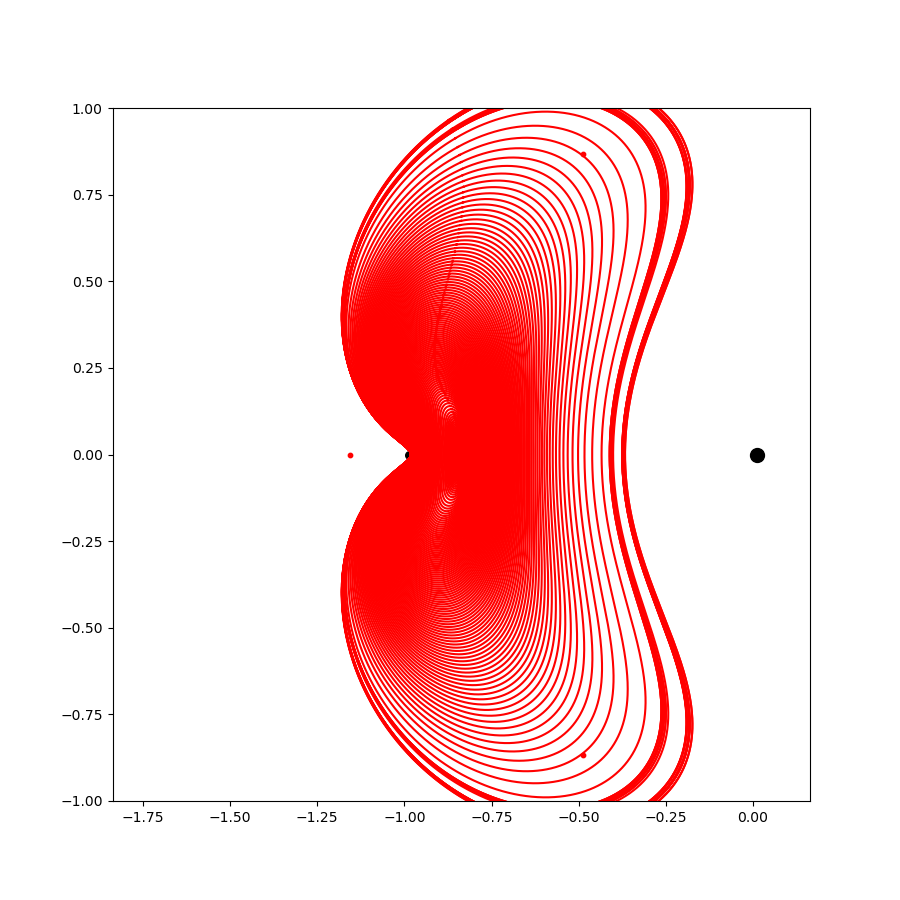

In [21]:
plt.figure(figsize=(9,9))

ax = plt.subplot(1,1,1)
# We find the postiion of the lagrangian points
xL1, xL2, xL3, xL45, yL45 = compute_L_points(mu, f[3])

# Plot the lagrangian points and primaries
zoom=1.
ax.set_xlim(xL1-zoom, xL1+zoom)
ax.set_ylim(-zoom, +zoom)
ax.scatter(mu, 0, c='k', s=100)
ax.scatter(mu-1, 0, c='k', s=30)
ax.scatter(xL1, 0, c='r', s=10)
ax.scatter(xL2, 0, c='r', s=10)
ax.scatter(xL3, 0, c='r', s=10)
ax.scatter(-0.5+mu, yL45, c='r', s=10)
ax.scatter(-0.5+mu, -yL45, c='r', s=10)

Finally we loop over the predictor-corrector and plot each orbit found.

In [22]:
#Set to true to get more info on the iterations
verbose = False
start_time = time.time()
# Main iterations
for i in range(200):
    # We call the predictor
    predicted, taux, tauT = predictor(new_ic, new_period, ds)
    # We call the corrector, if it fails (A^tA goes singular) we decrease the pseudo arc-length and try again
    try:
        corrected_N = corrector_Newton(new_ic, new_period, predicted[:,0], taux, tauT, ds, tol=1e-15)
        # Check convergence
        errN, Phi = full_system(new_ic, new_period, corrected_N, taux, tauT,ds)
        err = np.linalg.norm(errN)
        # Log
        if verbose:
            print("ds:", ds, "err:", err)
        # Accept the step
        if err < 1e-12:
            new_ic = new_ic + corrected_N[:6]
            new_period = new_period + corrected_N[6]
            if verbose: 
                print("Converged - increase ds")
            ds*=1.2
            if ds >0.05:
                ds=0.05
            # Reset the state
            ta.time = 0
            ta.state[:] = new_ic.tolist() + ic_var
            # Time grid
            t_grid = np.linspace(0, new_period, 2000)
            # Propagate
            out = ta.propagate_grid(t_grid)
            # Plot
            ax.plot(out[4][:, 0], out[4][:, 1],'r')
        # Reject the step
        else:
            ds/=1.1
            if verbose:
                print("Low Precision - reducing ds")
    # The (A^T A) matrix was likely singular, we reduce the step ad try again.
    except:
        if verbose:
            print("Singular matrix - reducing ds")
        ds/=1.1
print("--- %s seconds --- to do the iterations" % (time.time() - start_time))

--- 33.33539938926697 seconds --- to do the iterations
